In [17]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [18]:
import numpy as np 

def plot_images(imgs, grid_size = 5):
    """
    imgs: vector containing all the numpy images
    grid_size: 2x2 or 5x5 grid containing images
    """
     
    fig = plt.figure(figsize = (8, 8))
    columns = rows = grid_size
    plt.title("Training Images")

    for i in range(1, columns*rows +1):
        plt.axis("off")
        fig.add_subplot(rows, columns, i)
        if i >= len(imgs):
            break
        plt.imshow(imgs[i])
    plt.show()

imgs = np.load('../pixel_characters/8bit_characters_32x32.npz')

from torch.utils.data import Dataset, DataLoader

class PixelCharacterDataset(Dataset):
    """Human Faces dataset."""
 
    def __init__(self, npz_imgs):
        """
        Args:
            npz_imgs (string): npz file with all the images (created in gan.ipynb)
        """
        self.imgs = npz_imgs
 
    def __len__(self):
        return len(self.imgs)
 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
 
        image = self.imgs[idx]
 
        return image

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # input to generator is something like (batch_size, 100, 1, 1)
        # this means that we are passing a batch of 32 100 random numbers to the generator
        self.model = nn.Sequential(
          nn.ConvTranspose2d(in_channels = 100, out_channels = 512 , kernel_size = 4, stride = 1, padding = 0, bias = False),
          # the output from the above will be b_size ,512, 4,4
          nn.BatchNorm2d(num_features = 512), # From an input of size (b_size, C, H, W), pick num_features = C
          nn.ReLU(inplace = True),
 
          nn.ConvTranspose2d(in_channels = 512, out_channels = 256 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,256, 8,8
          nn.BatchNorm2d(num_features = 256),
          nn.ReLU(inplace = True),
 
          nn.ConvTranspose2d(in_channels = 256, out_channels = 128 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,128, 16,16
          nn.BatchNorm2d(num_features = 128),
          nn.ReLU(inplace = True),
 
          nn.ConvTranspose2d(in_channels = 128, out_channels = 3 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,3, 32,32
          nn.Tanh()
         
        )
 
    def forward(self, x):
        return self.model(x)


In [20]:
class Discriminator(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model = nn.Sequential(
 
            # input is (3, 32, 32)
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32, 16, 16
            nn.LeakyReLU(0.2, inplace=True),
 
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32*2, 8, 8
            nn.BatchNorm2d(32 * 2),
            nn.LeakyReLU(0.2, inplace=True),
 
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32*4, 4, 4
            nn.BatchNorm2d(32 * 4),
            nn.LeakyReLU(0.2, inplace=True),
 
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 256, 2, 2
            # NOTE: spatial size of this layer is 2x2, hence in the final layer, the kernel size must be 2 instead (or smaller than) 4
            nn.BatchNorm2d(32 * 8),
            nn.LeakyReLU(0.2, inplace=True),
 
            nn.Conv2d(in_channels = 256, out_channels = 1, kernel_size = 2, stride = 2, padding = 0, bias=False),
            # ouput from above layer is b_size, 1, 1, 1
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)
    




Manual seeding

In [21]:
torch.manual_seed(111)

In [22]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device.index)
print(device.type)

None
cuda


We will need to perform conversions to our grayscale images

In [23]:
transform = transforms.Compose(
    # to tensor converts data to a pytorch tensor
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    # to tensor makes value between 0 and 1
    # normalize makes value between -1 and 1
    # we do this by subtracting 0.5 from each value and dividing by 0.5
)

In [24]:
train_set = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)

In [25]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

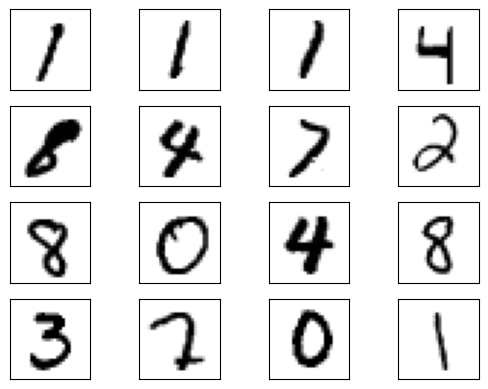

In [26]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    # cmap="gray_r" makes the image black and white
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])


Creating a discriminator that receives a 28 x 28 pixel image

In [27]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # we flatten the image to a vector of 784
            
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            # our latent space vector is 1 dimensional
            # the shape of it is 32 x 1
            nn.Sigmoid(),
        )

    def forward(self, img, c):
        # the c is the label of the image
        # it is a one hot encoded vector
        # original shape of input is 32 x 1 x 28 x 28
        # x.size(0) is 32
        # With x.view, we flatten the image to a vector of 784
        img = img.view(img.size(0), 784)
        x = torch.cat([img, c], dim=1)
        x = self.model(x)
        return x

In [28]:
discriminator = Discriminator().to(device=device)

In [29]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # The original latent space vector is 100
            # We add 10 because we want a Conditional GAN
            # The 10 is the number of classes (0-9 MNIST digits)
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            # We use tanh to make sure the output is between -1 and 1
            nn.Tanh(),
        )

    def forward(self, z, c):
        x = torch.cat([z,c], dim=1)
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

Train the models

In [30]:
lr = 0.0001
num_epochs = 30
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [31]:
def label_to_onehot(labels, length=10):
    """
    :param labels: torch.Size([N, 1])
    :param length: M
    :return: torch.Size([M, M])
    """
    batch_size = labels.size(0)
    canvas = torch.zeros(batch_size, length)
    labels = labels.view(-1, 1)
    return canvas.scatter_(1, labels, 1)


In [32]:
print(device)

cuda


In [33]:
random_label = torch.randint(0, 10, (batch_size,)).long()
onehot = label_to_onehot(random_label).to(device=device)
real_samples = real_samples.to(device=device)
real_samples_labels = torch.ones((batch_size, 1)).to(
    device=device
)
latent_space_samples = torch.randn((batch_size, 100)).to(
    device=device
)
generated_samples = generator(latent_space_samples, onehot)

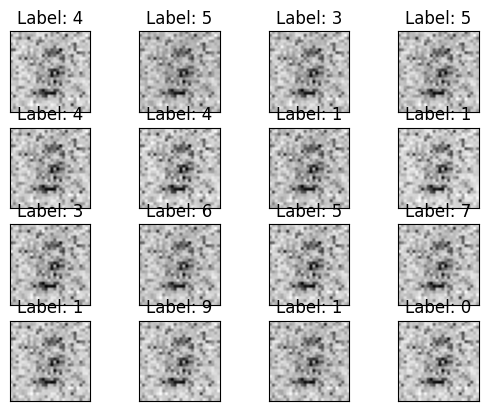

Epoch: 0 Loss D.: 0.5417160391807556
Epoch: 0 Loss G.: 0.5547159314155579


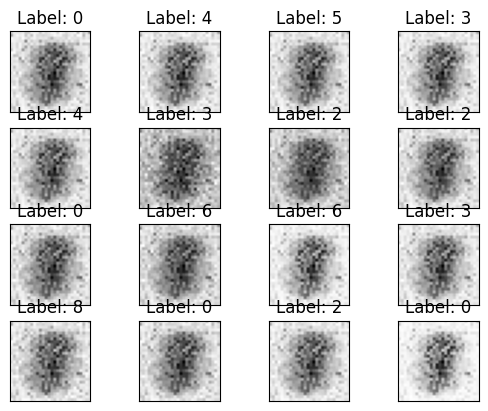

Epoch: 1 Loss D.: 0.0648423433303833
Epoch: 1 Loss G.: 3.0315330028533936


KeyboardInterrupt: 

In [34]:
latent_space_samples_test = torch.randn(batch_size, 100).to(device=device)


for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        onehot = label_to_onehot(mnist_labels).to(device=device)
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples, onehot)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )
        onehot_two = torch.cat((onehot, onehot))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples, onehot_two)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples, onehot)
        output_discriminator_generated = discriminator(generated_samples, onehot)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            # Visualize the generated digits from the latent space
            latent_space_samples = torch.randn(batch_size, 100).to(device=device)
            generated_samples = generator(latent_space_samples, onehot)
            generated_samples = generated_samples.cpu().detach()
            generated_samples = generated_samples.view(-1, 28, 28)
            for i in range(16):
                ax = plt.subplot(4, 4, i + 1)
                ax.set_title(f"Label: {mnist_labels[i].item()}")
                plt.imshow(generated_samples[i], cmap="gray_r")
                plt.xticks([])
                plt.yticks([])
            plt.show()
            plt.close()
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

In [31]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

In [32]:
random_label = torch.randint(0, 10, (batch_size,)).long()
print(random_label)
onehot_random = label_to_onehot(random_label).to(device=device)

latent_space_samples_test = torch.randn(batch_size, 100).to(device=device)
generated_samples_test = generator(latent_space_samples_test, onehot_random)


tensor([7, 0, 3, 4, 8, 5, 5, 7, 7, 2, 7, 8, 1, 5, 6, 7, 8, 7, 5, 6, 5, 1, 1, 4,
        7, 5, 8, 3, 2, 2, 7, 2])


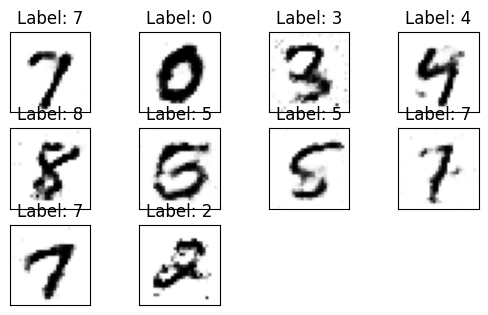

In [33]:
generated_samples_test = generated_samples_test.cpu().detach()
for i in range(10):
    ax = plt.subplot(4, 4, i + 1)
    ax.set_title(f"Label: {random_label[i]}")
    plt.imshow(generated_samples_test[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
    